In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

# 1. Import the learning and text files

First, I need to import and clean the data. Some attribute from the origin dataset which can directly infer one's income status should not be used in the classifiers. The data you provide has already ignored them. I followed the instruction and added header for this dataframe.

I encounter first challenging here: it seems I missed one label. I had to spend quite a while to check each label manually and found out second last column is actually a nominal variable "year".

In [2]:
names = ["AAGE", "ACLSWKR", "ADTIND", "ADTOCC", "AHGA", "AHRSPAY", "AHSCOL", "AMARITL", "AMJIND", "AMJOCC", "ARACE", "AREORGN", "ASEX", "AUNMEM", "AUNTYPE", "AWKSTAT", "CAPGAIN", "CAPLOSS", "DIVVAL", "FILESTAT", "GRINREG", "GRINST", "HHDFMX", "HHDREL", "MARSUPWT", "MIGMTR1", "MIGMTR3", "MIGMTR4", "MIGSAME", "MIGSUN", "NOEMP", "PARENT", "PEFNTVTY", "PEMNTVTY", "PENATVTY", "PRCITSHP", "SEOTR", "VETQVA", "VETYN", "WKSWORK", "YEAR", "Y"]
train = pd.read_csv("census_income_learn.csv",
                 na_values=[" ?", "?"],
                 header = None,
                 names = names)
test = pd.read_csv("census_income_test.csv",
                 na_values=[" ?", "?"],
                 header = None,
                 names = names)

In [3]:
train.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,Y
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,-50000
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,-50000
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,-50000
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000


# 2. Based on the learning file:

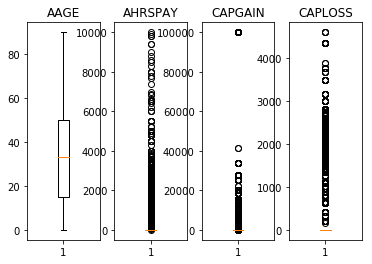

In [19]:
continuous_vars = [0, 5, 16, 17]
for i in range(len(continuous_vars)):
    plt.subplot(1,4,i+1)
    x = continuous_vars[i]
    plt.boxplot(train[names[x]])
    plt.title(names[x])

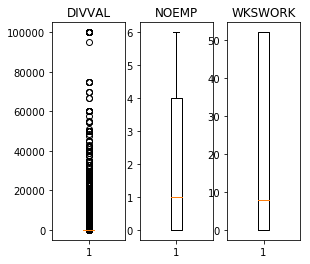

In [18]:
continuous_vars = [18, 30, 39]
for i in range(len(continuous_vars)):
    plt.subplot(1,4,i+1)
    x = continuous_vars[i]
    plt.boxplot(train[names[x]])
    plt.title(names[x])

We can see mean is nearly zero for 'wage per hour', 'cap gains', 'cap losses' and 'dividends'.

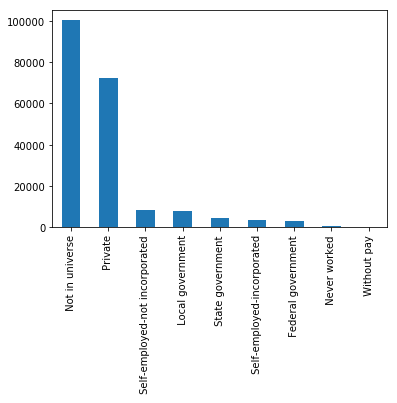

In [34]:
train["ACLSWKR"].value_counts().plot(kind='bar')

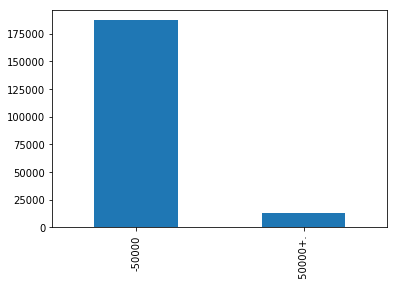

In [35]:
train["Y"].value_counts().plot(kind='bar')

First, let's check some nominal variable of the training set. As we can see from the "class of worker" graph. Lots of data are labeled with "Not in universe" which implies that the person was not a part of the population to which the question was directed. Thus, I deceided to view them as a category rather than missing data.

For the second graph, we can see the data is really imbalanced. Then just guessing all people saving less than \$50,000 / year would get a pretty good accuracy. Thus, I would to oversample the group of people saving more than \$50,000 / year in training set and use AUC (Area under the ROC curve) as the criterion for my classifiers. This could be viewed as the second challenge I met.

In [36]:
train.describe()

,AAGE,ADTIND,ADTOCC,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,MARSUPWT,NOEMP,SEOTR,VETYN,WKSWORK,YEAR
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


In [37]:
train.isnull().sum()

AAGE            0
ACLSWKR         0
ADTIND          0
ADTOCC          0
AHGA            0
AHRSPAY         0
AHSCOL          0
AMARITL         0
AMJIND          0
AMJOCC          0
ARACE           0
AREORGN         0
ASEX            0
AUNMEM          0
AUNTYPE         0
AWKSTAT         0
CAPGAIN         0
CAPLOSS         0
DIVVAL          0
FILESTAT        0
GRINREG         0
GRINST        708
HHDFMX          0
HHDREL          0
MARSUPWT        0
MIGMTR1     99696
MIGMTR3     99696
MIGMTR4     99696
MIGSAME         0
MIGSUN      99696
NOEMP           0
PARENT          0
PEFNTVTY     6713
PEMNTVTY     6119
PENATVTY     3393
PRCITSHP        0
SEOTR           0
VETQVA          0
VETYN           0
WKSWORK         0
YEAR            0
Y               0
dtype: int64

In [41]:
99696 / train.shape[0]

0.4996717170451527

From the result showed above, about half of the data for MIGMTR1, MIGMTR3, MIGMTR4, MIGSUN are missing. I prefer to drop them. For PEFNTVTY, PEMNTVTY, PENATVTY, I think k-nn imputation would be a good idea. However, due to the limitation of time, I would skip this part.

As I have to clean both datasets, I decide to concatenate train and test dataset together to save work. I also transfer nominal columns to several dummy variables in order to use machine learning algorithms for predicting.

In [3]:
tmp = train.append(test)
Y = tmp["Y"]
X = tmp.drop(["Y", "MIGMTR1", "MIGMTR3","MIGMTR4","MIGSUN"],1)
X.drop
X = pd.get_dummies(X)
Y[Y ==' 50000+.'] = 1
Y[Y ==' - 50000.'] = 0
Y[Y == "-50000"] = 0
Y = Y.astype(int)
X_train = X.iloc[:train.shape[0],]
X_test = X.iloc[train.shape[0]:,]
Y_train = Y.iloc[:train.shape[0],]
Y_test = Y.iloc[train.shape[0]:,]

/Users/chang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/chang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/chang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# 3. Choose the model that appears to have the highest performance based on a comparison between reality (the 42nd variable) and the model’s prediction. 

Now I have finished data cleaning, I would use Logistic Regression classifier to be benchmark.

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import linear_model
lr = linear_model.LogisticRegression()
lr.fit(X_train, Y_train)
Y_predict = lr.predict(X_train)
print('guessing: ' + str(1 - np.mean(Y_train)))
print('accuracy: ' + str(accuracy_score(Y_train, Y_predict)))
print('AUC: ' + str(roc_auc_score(Y_train, Y_predict)))

guessing: 0.9379419916500854
accuracy: 0.952431549245
AUC: 0.682922070466


As we can see from the predict result, the train accuracy is quite high. However, it's just a little better than guessing. Actually, AUC is a better metric which consider both positive rate and the false positive rate.

Let me do oversample and try the same classifier. Synthetic Minority Over-sampling Technique should perform better than random oversampling.

In [43]:
from imblearn.over_sampling import SMOTE
X_train_oversample, Y_train_oversample = SMOTE(ratio=0.5).fit_sample(X_train,Y_train)
clf = linear_model.LogisticRegression()
clf.fit(X_train_oversample, Y_train_oversample)
Y_predict = clf.predict(X_train)
print('guessing: ' + str(1 - np.mean(Y_train)))
print('accuracy: ' + str(accuracy_score(Y_train, Y_predict)))
print('AUC: ' + str(roc_auc_score(Y_train, Y_predict)))

guessing: 0.9379419916500854
accuracy: 0.904256652115
AUC: 0.855554719774


In [58]:
X_train_oversample, Y_train_oversample = SMOTE().fit_sample(X_train,Y_train)
lr = linear_model.LogisticRegression()
lr.fit(X_train_oversample, Y_train_oversample)
Y_predict = lr.predict(X_train)
print('guessing: ' + str(1 - np.mean(Y_train)))
print('accuracy: ' + str(accuracy_score(Y_train, Y_predict)))
print('AUC: ' + str(roc_auc_score(Y_train, Y_predict)))

guessing: 0.9379419916500854
accuracy: 0.850478390962
AUC: 0.863162954806


Though accuracy is keeping decreasing, the more data which saving more than \$50,000 / year I oversampled, the more AUC I gain. I used the origin data rather than oversampled data for measuring performance in order to match the distribution of test data.

In [16]:
X_train_oversample, Y_train_oversample = SMOTE().fit_sample(X_train,Y_train)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 15)
rf.fit(X_train_oversample, Y_train_oversample)
Y_predict = rf.predict(X_train)
print('guessing: ' + str(1 - np.mean(Y_train)))
print('accuracy: ' + str(accuracy_score(Y_train, Y_predict)))
print('AUC: ' + str(roc_auc_score(Y_train, Y_predict)))

guessing: 0.9379419916500854
accuracy: 0.939896653519
AUC: 0.768552594127


In [8]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X_train_oversample, Y_train_oversample)
Y_predict = ada.predict(X_train)
print('guessing: ' + str(1 - np.mean(Y_train)))
print('accuracy: ' + str(accuracy_score(Y_train, Y_predict)))
print('AUC: ' + str(roc_auc_score(Y_train, Y_predict)))

guessing: 0.9379419916500854
accuracy: 0.944457531212
AUC: 0.749489548688


For a dataset large like this one, my laptop is incapable of handling support vector machines or gradient boosting machine. So I just tried two more models.

Unexpectedly, Logistic Regression beats Adaboost. So I would check its weight on each variables and its performance on test set. 

# 4. Apply your model to the test file and measure it’s real performance on it 

In [13]:
Y_predict = lr.predict(X_test)
print('guessing: ' + str(1 - np.mean(Y_test)))
print('accuracy: ' + str(accuracy_score(Y_test, Y_predict)))
print('AUC: ' + str(roc_auc_score(Y_test, Y_predict)))

guessing: 0.937992421964275
accuracy: 0.848689881919
AUC: 0.865070333552


The result shows there's no overfitting.

Since all nominal feature from origin data are converted into dummy variable and most feature of X are dummy variabes. We can infer the importance of each variable without rescale them.

In [128]:
ascend = np.argsort(lr.coef_.flatten())
negative_feature = ()
negative_value = []
positive_feature = ()
positive_value = []
print("negative contributes")
for i in range(10):
    negative_feature = negative_feature + (X_train.columns.values[ascend[i]],)
    negative_value.append(lr.coef_.flatten()[ascend[i]])
for i in range(10):
    positive_feature = positive_feature + (X_train.columns.values[ascend[X_train.shape[1] - 1 -i]],)
    positive_value.append(lr.coef_.flatten()[ascend[X_train.shape[1] - 1 -i]])

negative contributes


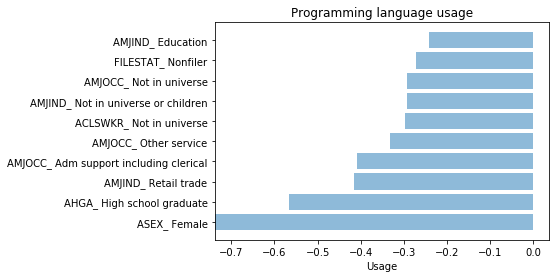

In [132]:
y_pos = np.arange(10)
plt.barh(y_pos, negative_value, align='center', alpha=0.5)
plt.yticks(y_pos, negative_feature)
plt.xlabel('coefficient')
plt.title('negative contribution features')

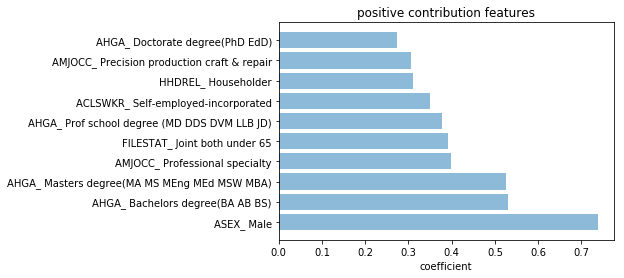

In [134]:
y_pos = np.arange(10)
plt.barh(y_pos, positive_value, align='center', alpha=0.5)
plt.yticks(y_pos, positive_feature)
plt.xlabel('coefficient')
plt.title('positive contribution features')

From the graphs above, we can see gender, education and major occupation would determinate one's saving greatly.

As final exam approaching, I cannot spend enough time on this data challenge. If I have some more time, I would try to imputate missing data and use grid search to improve AUC. These 